# 1 . Basal 1 (1–2 min, ojos abiertos - punto fijo)

[Basal 1] Potencias (µV²)  α:6.895  β:9.267  γ:2.405


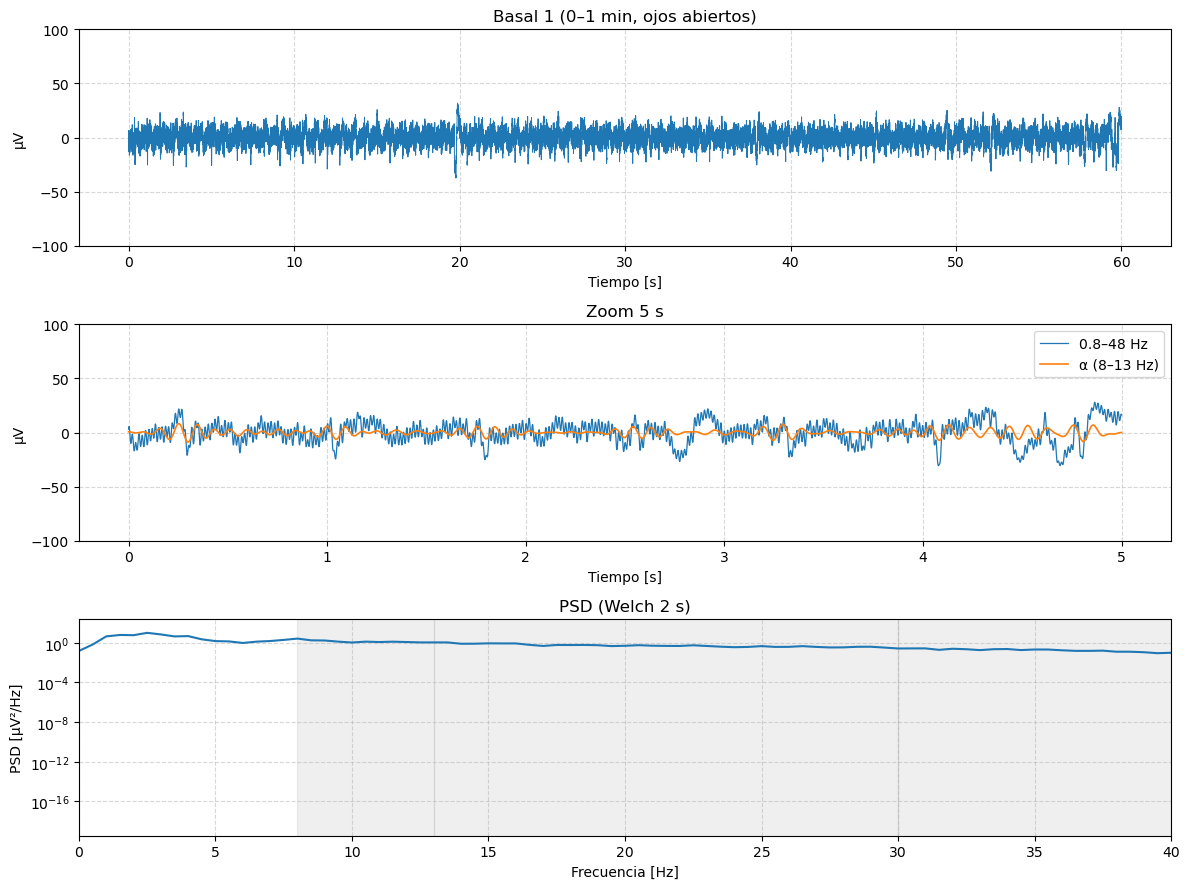

In [19]:
import json, re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch

# ===== Config =====
ruta = "Data_EEG/lab5.txt"
bloque = (0, 60)                # 0–1 min
zoom_window = 5.0               # s
f_lo, f_hi = 0.8, 48.0          # Hz
red, Q_notch = 50.0, 30.0       # cambia red=60.0 si tu red es 60 Hz
BANDAS = {"alpha": (8,13), "beta": (13,30), "gamma": (30,48)}

# ===== Leer header (fs y columna A4) =====
with open(ruta, "r", encoding="utf-8", errors="ignore") as f:
    hdr = []
    while True:
        p = f.tell(); ln = f.readline()
        if not ln: break
        if ln.startswith("#"): hdr.append(ln[1:].strip())
        else: f.seek(p); break
meta = json.loads(re.search(r"\{.*\}", "\n".join(hdr), re.DOTALL).group(0))
dev = next(iter(meta))
fs = int(meta[dev]["sampling rate"])
idx_A4 = meta[dev]["column"].index("A4")

# ===== Cargar y convertir ADC→µV (BITalino EEG) =====
adc = np.genfromtxt(ruta, usecols=[idx_A4], comments="#", dtype=float)
adc = adc[~np.isnan(adc)]
x = (adc - 512.0) * (3.3/1023.0) / 40000.0 * 1e6  # µV

# ===== Filtros: notch + band-pass =====
bN, aN = iirnotch(red/(fs/2), Q_notch)
x = filtfilt(bN, aN, x, method="gust")
bB, aB = butter(4, [f_lo/(fs/2), f_hi/(fs/2)], btype="band")
x = filtfilt(bB, aB, x, method="gust")

# ===== Recorte del bloque =====
i1, i2 = int(bloque[0]*fs), min(int(bloque[1]*fs), len(x))
t = np.arange(len(x))/fs
t_seg, x_seg = t[i1:i2], x[i1:i2]

# ===== Welch (2 s) y potencias por banda (np.trapezoid) =====
f, Pxx = welch(x_seg, fs=fs, nperseg=2*fs, noverlap=fs)
def band_power(f, P, a, b):
    m = (f >= a) & (f <= b)
    return np.trapezoid(P[m], f[m]) if np.any(m) else 0.0
bp = {k: band_power(f, Pxx, a, b) for k,(a,b) in BANDAS.items()}
print("[Basal 1] Potencias (µV²)  α:{:.3f}  β:{:.3f}  γ:{:.3f}".format(bp["alpha"], bp["beta"], bp["gamma"]))

# ===== Zoom 5 s (final del bloque) y α superpuesta =====
t2z = t_seg[-1]; t1z = max(t2z - zoom_window, t_seg[0])
j1, j2 = int(t1z*fs), int(t2z*fs)
t_zoom, x_zoom = t[j1:j2], x[j1:j2]
bA, aA = butter(4, [8/(fs/2), 13/(fs/2)], btype="band")
x_alpha = filtfilt(bA, aA, x_zoom, method="gust")

# ===== Gráficas =====
plt.figure(figsize=(12,9))
ax1 = plt.subplot(3,1,1); ax1.plot(t_seg - t_seg[0], x_seg, lw=.7)
ax1.set_title("Basal 1 (0–1 min, ojos abiertos)"); ax1.set_xlabel("Tiempo [s]"); ax1.set_ylabel("µV")
ax1.grid(True, ls="--", alpha=.5); ax1.set_ylim(-100, 100)

ax2 = plt.subplot(3,1,2)
ax2.plot(t_zoom - t_zoom[0], x_zoom, lw=.9, label="0.8–48 Hz")
ax2.plot(t_zoom - t_zoom[0], x_alpha, lw=1.2, label="α (8–13 Hz)")
ax2.set_title("Zoom 5 s"); ax2.set_xlabel("Tiempo [s]"); ax2.set_ylabel("µV")
ax2.grid(True, ls="--", alpha=.5); ax2.legend(); ax2.set_ylim(-100, 100)

ax3 = plt.subplot(3,1,3)
ax3.semilogy(f, Pxx)
for a,b in BANDAS.values(): ax3.axvspan(a, b, color="grey", alpha=.12)
ax3.set_xlim(0, 40); ax3.set_xlabel("Frecuencia [Hz]"); ax3.set_ylabel("PSD [µV²/Hz]")
ax3.set_title("PSD (Welch 2 s)"); ax3.grid(True, ls="--", alpha=.5)
plt.tight_layout(); plt.show()


# 2. Basal 2 (1–2 min, ojos cerrados)

[Basal 1] Potencias (µV²)  α:33.567  β:23.864  γ:4.100


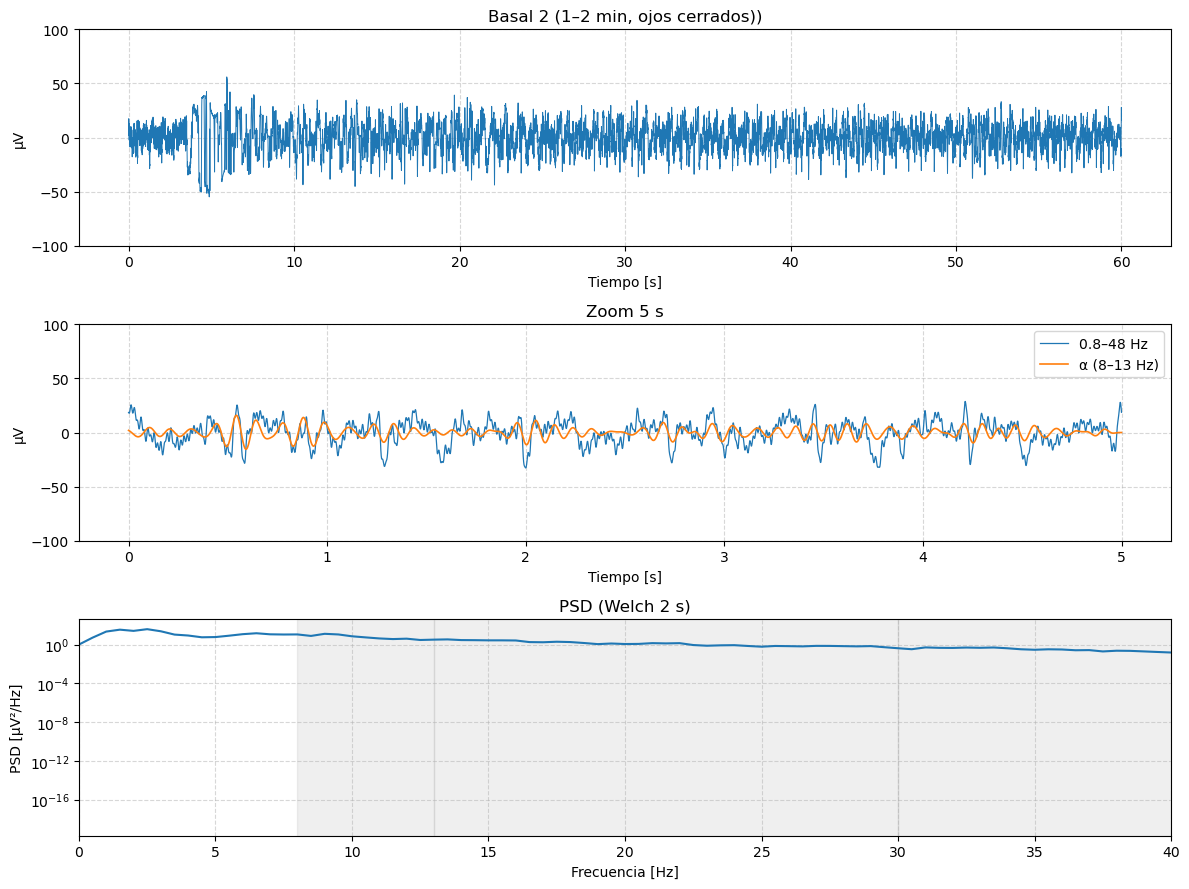

In [22]:
import json, re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch

# ===== Config =====
ruta = "Data_EEG/lab5.txt"
bloque = (60, 120)                # 1–2 min
zoom_window = 5.0               # s
f_lo, f_hi = 0.8, 48.0          # Hz
red, Q_notch = 50.0, 30.0       # cambia red=60.0 si tu red es 60 Hz
BANDAS = {"alpha": (8,13), "beta": (13,30), "gamma": (30,48)}

# ===== Leer header (fs y columna A4) =====
with open(ruta, "r", encoding="utf-8", errors="ignore") as f:
    hdr = []
    while True:
        p = f.tell(); ln = f.readline()
        if not ln: break
        if ln.startswith("#"): hdr.append(ln[1:].strip())
        else: f.seek(p); break
meta = json.loads(re.search(r"\{.*\}", "\n".join(hdr), re.DOTALL).group(0))
dev = next(iter(meta))
fs = int(meta[dev]["sampling rate"])
idx_A4 = meta[dev]["column"].index("A4")

# ===== Cargar y convertir ADC→µV (BITalino EEG) =====
adc = np.genfromtxt(ruta, usecols=[idx_A4], comments="#", dtype=float)
adc = adc[~np.isnan(adc)]
x = (adc - 512.0) * (3.3/1023.0) / 40000.0 * 1e6  # µV

# ===== Filtros: notch + band-pass =====
bN, aN = iirnotch(red/(fs/2), Q_notch)
x = filtfilt(bN, aN, x, method="gust")
bB, aB = butter(4, [f_lo/(fs/2), f_hi/(fs/2)], btype="band")
x = filtfilt(bB, aB, x, method="gust")

# ===== Recorte del bloque =====
i1, i2 = int(bloque[0]*fs), min(int(bloque[1]*fs), len(x))
t = np.arange(len(x))/fs
t_seg, x_seg = t[i1:i2], x[i1:i2]

# ===== Welch (2 s) y potencias por banda (np.trapezoid) =====
f, Pxx = welch(x_seg, fs=fs, nperseg=2*fs, noverlap=fs)
def band_power(f, P, a, b):
    m = (f >= a) & (f <= b)
    return np.trapezoid(P[m], f[m]) if np.any(m) else 0.0
bp = {k: band_power(f, Pxx, a, b) for k,(a,b) in BANDAS.items()}
print("[Basal 1] Potencias (µV²)  α:{:.3f}  β:{:.3f}  γ:{:.3f}".format(bp["alpha"], bp["beta"], bp["gamma"]))

# ===== Zoom 5 s (final del bloque) y α superpuesta =====
t2z = t_seg[-1]; t1z = max(t2z - zoom_window, t_seg[0])
j1, j2 = int(t1z*fs), int(t2z*fs)
t_zoom, x_zoom = t[j1:j2], x[j1:j2]
bA, aA = butter(4, [8/(fs/2), 13/(fs/2)], btype="band")
x_alpha = filtfilt(bA, aA, x_zoom, method="gust")

# ===== Gráficas =====
plt.figure(figsize=(12,9))
ax1 = plt.subplot(3,1,1); ax1.plot(t_seg - t_seg[0], x_seg, lw=.7)
ax1.set_title("Basal 2 (1–2 min, ojos cerrados))"); ax1.set_xlabel("Tiempo [s]"); ax1.set_ylabel("µV")
ax1.grid(True, ls="--", alpha=.5); ax1.set_ylim(-100, 100)

ax2 = plt.subplot(3,1,2)
ax2.plot(t_zoom - t_zoom[0], x_zoom, lw=.9, label="0.8–48 Hz")
ax2.plot(t_zoom - t_zoom[0], x_alpha, lw=1.2, label="α (8–13 Hz)")
ax2.set_title("Zoom 5 s"); ax2.set_xlabel("Tiempo [s]"); ax2.set_ylabel("µV")
ax2.grid(True, ls="--", alpha=.5); ax2.legend(); ax2.set_ylim(-100, 100)

ax3 = plt.subplot(3,1,3)
ax3.semilogy(f, Pxx)
for a,b in BANDAS.values(): ax3.axvspan(a, b, color="grey", alpha=.12)
ax3.set_xlim(0, 40); ax3.set_xlabel("Frecuencia [Hz]"); ax3.set_ylabel("PSD [µV²/Hz]")
ax3.set_title("PSD (Welch 2 s)"); ax3.grid(True, ls="--", alpha=.5)
plt.tight_layout(); plt.show()


# 3. Tarea cognitiva (2–4 min)

[Basal 1] Potencias (µV²)  α:10.125  β:8.766  γ:1.827


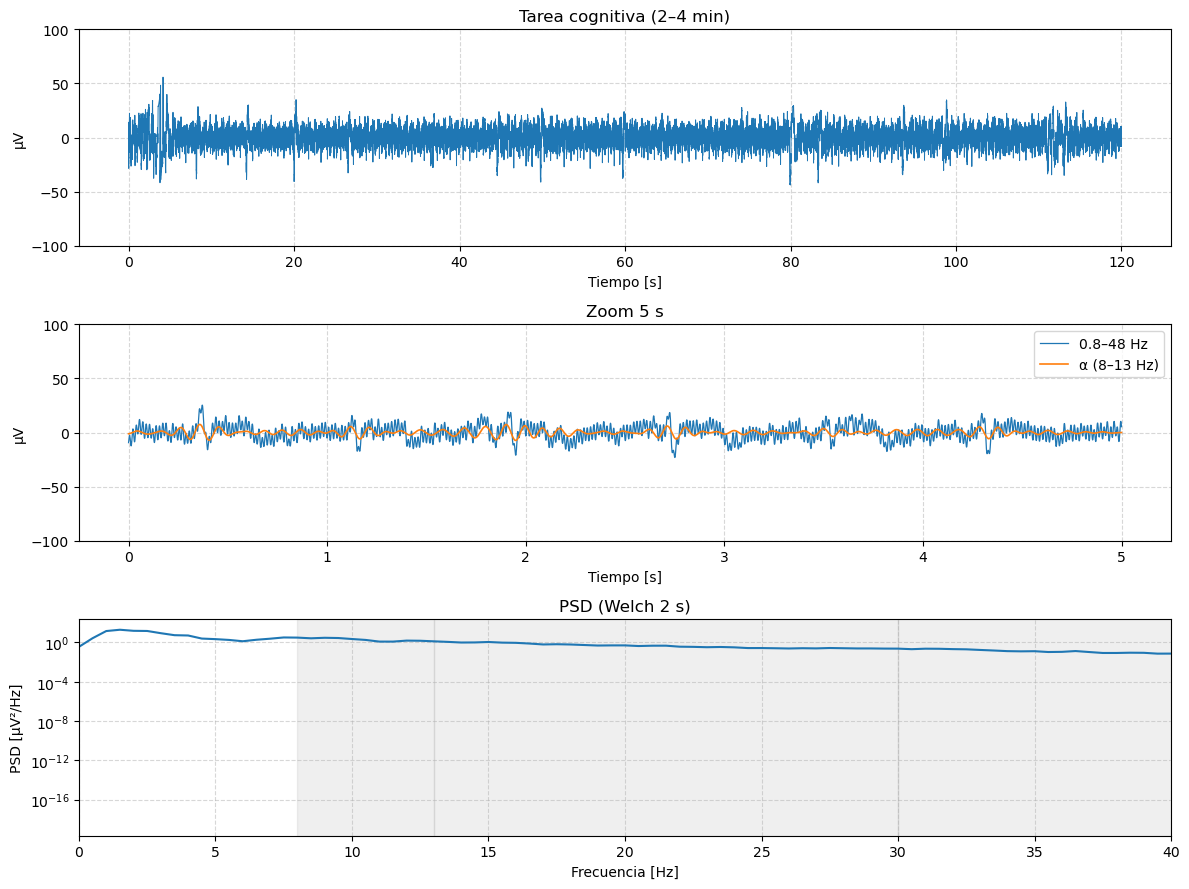

In [23]:
import json, re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch

# ===== Config =====
ruta = "Data_EEG/lab5.txt"
bloque = (120, 240)                # 2–4 min
zoom_window = 5.0               # s
f_lo, f_hi = 0.8, 48.0          # Hz
red, Q_notch = 50.0, 30.0       # cambia red=60.0 si tu red es 60 Hz
BANDAS = {"alpha": (8,13), "beta": (13,30), "gamma": (30,48)}

# ===== Leer header (fs y columna A4) =====
with open(ruta, "r", encoding="utf-8", errors="ignore") as f:
    hdr = []
    while True:
        p = f.tell(); ln = f.readline()
        if not ln: break
        if ln.startswith("#"): hdr.append(ln[1:].strip())
        else: f.seek(p); break
meta = json.loads(re.search(r"\{.*\}", "\n".join(hdr), re.DOTALL).group(0))
dev = next(iter(meta))
fs = int(meta[dev]["sampling rate"])
idx_A4 = meta[dev]["column"].index("A4")

# ===== Cargar y convertir ADC→µV (BITalino EEG) =====
adc = np.genfromtxt(ruta, usecols=[idx_A4], comments="#", dtype=float)
adc = adc[~np.isnan(adc)]
x = (adc - 512.0) * (3.3/1023.0) / 40000.0 * 1e6  # µV

# ===== Filtros: notch + band-pass =====
bN, aN = iirnotch(red/(fs/2), Q_notch)
x = filtfilt(bN, aN, x, method="gust")
bB, aB = butter(4, [f_lo/(fs/2), f_hi/(fs/2)], btype="band")
x = filtfilt(bB, aB, x, method="gust")

# ===== Recorte del bloque =====
i1, i2 = int(bloque[0]*fs), min(int(bloque[1]*fs), len(x))
t = np.arange(len(x))/fs
t_seg, x_seg = t[i1:i2], x[i1:i2]

# ===== Welch (2 s) y potencias por banda (np.trapezoid) =====
f, Pxx = welch(x_seg, fs=fs, nperseg=2*fs, noverlap=fs)
def band_power(f, P, a, b):
    m = (f >= a) & (f <= b)
    return np.trapezoid(P[m], f[m]) if np.any(m) else 0.0
bp = {k: band_power(f, Pxx, a, b) for k,(a,b) in BANDAS.items()}
print("[Basal 1] Potencias (µV²)  α:{:.3f}  β:{:.3f}  γ:{:.3f}".format(bp["alpha"], bp["beta"], bp["gamma"]))

# ===== Zoom 5 s (final del bloque) y α superpuesta =====
t2z = t_seg[-1]; t1z = max(t2z - zoom_window, t_seg[0])
j1, j2 = int(t1z*fs), int(t2z*fs)
t_zoom, x_zoom = t[j1:j2], x[j1:j2]
bA, aA = butter(4, [8/(fs/2), 13/(fs/2)], btype="band")
x_alpha = filtfilt(bA, aA, x_zoom, method="gust")

# ===== Gráficas =====
plt.figure(figsize=(12,9))
ax1 = plt.subplot(3,1,1); ax1.plot(t_seg - t_seg[0], x_seg, lw=.7)
ax1.set_title("Tarea cognitiva (2–4 min)"); ax1.set_xlabel("Tiempo [s]"); ax1.set_ylabel("µV")
ax1.grid(True, ls="--", alpha=.5); ax1.set_ylim(-100, 100)

ax2 = plt.subplot(3,1,2)
ax2.plot(t_zoom - t_zoom[0], x_zoom, lw=.9, label="0.8–48 Hz")
ax2.plot(t_zoom - t_zoom[0], x_alpha, lw=1.2, label="α (8–13 Hz)")
ax2.set_title("Zoom 5 s"); ax2.set_xlabel("Tiempo [s]"); ax2.set_ylabel("µV")
ax2.grid(True, ls="--", alpha=.5); ax2.legend(); ax2.set_ylim(-100, 100)

ax3 = plt.subplot(3,1,3)
ax3.semilogy(f, Pxx)
for a,b in BANDAS.values(): ax3.axvspan(a, b, color="grey", alpha=.12)
ax3.set_xlim(0, 40); ax3.set_xlabel("Frecuencia [Hz]"); ax3.set_ylabel("PSD [µV²/Hz]")
ax3.set_title("PSD (Welch 2 s)"); ax3.grid(True, ls="--", alpha=.5)
plt.tight_layout(); plt.show()

# 4. Artefactos (4–6 min) + parpadeos y masticar

[DEBUG] fs=1000 Hz, p95(|LP8|)≈35.4 µV, MAD≈6.5, sigma≈9.6
[DEBUG] thr_mad≈45.0 µV, thr_rms≈34.8, z-thr=3.0
[Artefactos] Parpadeos detectados: 25
[Artefactos] Potencias (µV²)  α:9.666  β:15.319  γ:5.169


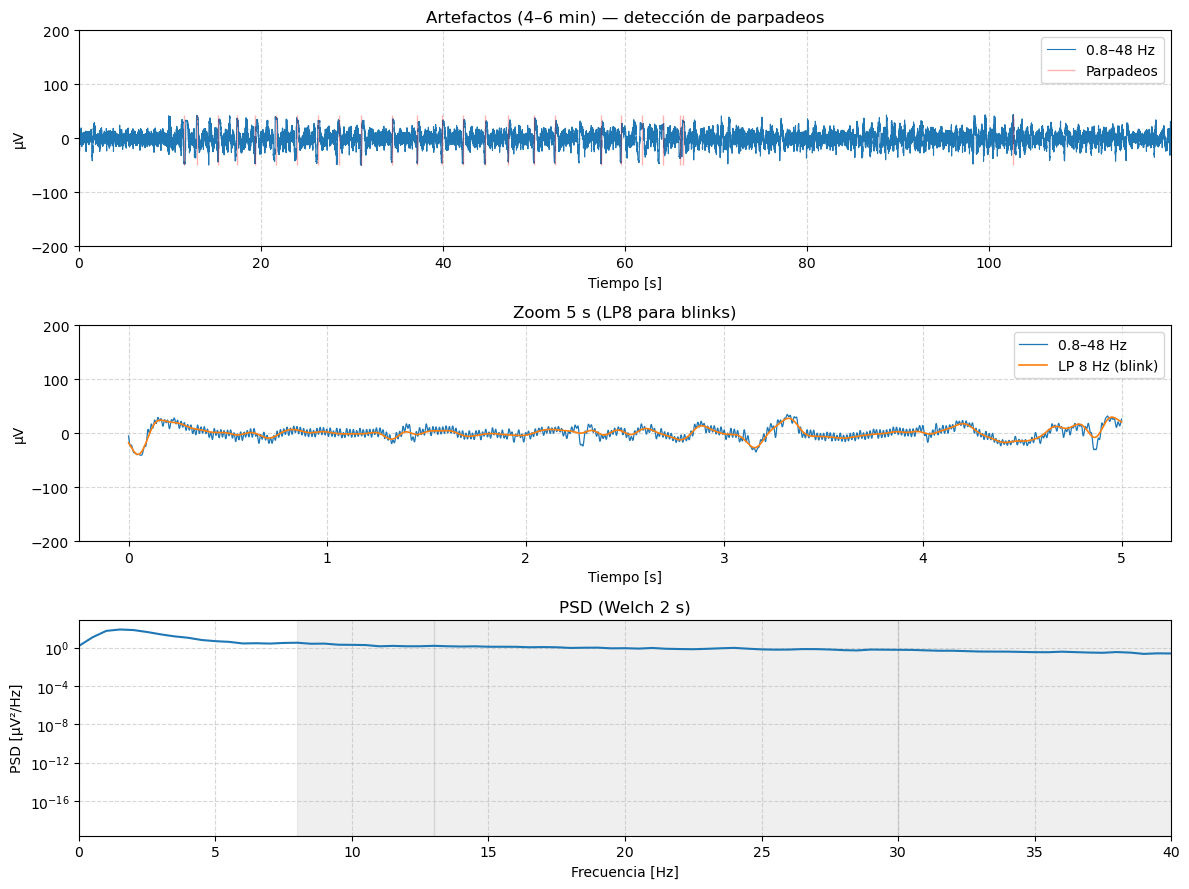

In [29]:
# EEG_04-06_artefactos.py  —  Detección de parpadeos (corregido y robusto)

import json, re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch, find_peaks

# ================== Config ==================
ruta = "Data_EEG/lab5.txt"
bloque = (240, 360)          # 4–6 min
zoom_window = 5.0            # s

# Visualización/PSD:
viz_lo, viz_hi = 0.8, 48.0   # Hz

# Detección de parpadeos (señal blanda):
lp_cut = 8.0                 # Hz (LOWPASS para blinks)
red, Q_notch = 50.0, 30.0    # 50 Hz Perú; usa 60.0 si corresponde

# Parámetros de decisión (ajustables)
REFRACT = 0.30               # s – distancia mínima entre blinks
W_MIN, W_MAX = 0.05, 0.60    # s – ancho típico
PROM_MIN = 5.0               # µV – prominencia mínima
Z_THR = 3.0                  # umbral z-score
RMS_WIN = 0.150              # s – ventana RMS
RMS_K = 3.0                  # multiplicador para umbral RMS
MAD_K = 4.0                  # multiplicador MAD
FLOOR_UV = 10.0              # µV – piso mínimo de umbral

BANDAS = {"alpha": (8,13), "beta": (13,30), "gamma": (30,48)}

# ================== Utilidades ==================
def make_butter_low(fc, fs, order=4):
    ny = fs/2
    return butter(order, fc/ny, btype="low")

def make_butter_band(lo, hi, fs, order=4):
    ny = fs/2
    return butter(order, [lo/ny, hi/ny], btype="band")

def safe_filtfilt(b, a, x):
    """filtfilt tolerante a segmentos cortos/ruidosos."""
    x = np.asarray(x, float)
    n = max(len(a), len(b))
    padlen = max(0, min(3*(n-1), x.size-1))
    return filtfilt(b, a, x, method="pad", padlen=padlen)

def fill_nonfinite(x):
    """Interpola NaN/Inf y extrapola bordes."""
    x = np.asarray(x, float)
    ok = np.isfinite(x)
    if ok.all():
        return x
    idx = np.arange(x.size)
    if ok.any():
        y = np.interp(idx, idx[ok], x[ok])
        first, last = np.flatnonzero(ok)[0], np.flatnonzero(ok)[-1]
        y[:first] = y[first]; y[last+1:] = y[last]
        return y
    return np.zeros_like(x)

def band_power(f, P, a, b):
    m = (f>=a) & (f<=b)
    return np.trapezoid(P[m], f[m]) if np.any(m) else 0.0

def merge_peaks(peaks_list, fs, refract_s):
    """Une listas de picos respetando periodo refractario."""
    arrs = [p for p in peaks_list if p is not None and p.size>0]
    if not arrs: return np.array([], int)
    all_idx = np.unique(np.concatenate(arrs))
    if all_idx.size == 0: return all_idx
    all_idx.sort()
    merged = [all_idx[0]]
    refr = int(refract_s*fs)
    for k in all_idx[1:]:
        if k - merged[-1] >= refr:
            merged.append(k)
    return np.array(merged, int)

# ================== Leer header (fs y columna A4) ==================
with open(ruta,"r",encoding="utf-8",errors="ignore") as f:
    hdr=[]
    while True:
        p=f.tell(); ln=f.readline()
        if not ln: break
        if ln.startswith("#"): hdr.append(ln[1:].strip())
        else: f.seek(p); break
meta = json.loads(re.search(r"\{.*\}", "\n".join(hdr), re.DOTALL).group(0))
dev = next(iter(meta))
fs = int(meta[dev]["sampling rate"])
idx_A4 = meta[dev]["column"].index("A4")

# ================== Cargar y convertir ADC→µV ==================
adc = np.genfromtxt(ruta, usecols=[idx_A4], comments="#", dtype=float,
                    autostrip=True, invalid_raise=False, filling_values=np.nan)
adc = fill_nonfinite(adc)
x_uV = (adc - 512.0) * (3.3/1023.0) / 40000.0 * 1e6
x_uV = fill_nonfinite(x_uV)

# ================== Notch ==================
bN, aN = iirnotch(red/(fs/2), Q_notch)
x_uV = safe_filtfilt(bN, aN, x_uV)

# ================== Señales filtradas ==================
# Visualización (0.8–48 Hz)
bViz, aViz = make_butter_band(viz_lo, viz_hi, fs, order=4)
x_viz = safe_filtfilt(bViz, aViz, x_uV)
# Blink detector (LP 8 Hz)
bLP, aLP = make_butter_low(lp_cut, fs, order=4)
x_lp = safe_filtfilt(bLP, aLP, x_uV)

# ================== Recorte del bloque ==================
i1, i2 = int(bloque[0]*fs), min(int(bloque[1]*fs), len(x_lp))
t = np.arange(len(x_lp))/fs
t_seg = t[i1:i2]
sig_lp  = x_lp[i1:i2]
sig_viz = x_viz[i1:i2]

# ================== Diagnóstico & umbrales ==================
p95 = np.percentile(np.abs(sig_lp), 95)
mad = np.median(np.abs(sig_lp - np.median(sig_lp)))
sigma = 1.4826 * mad
z = (sig_lp - np.median(sig_lp)) / (np.std(sig_lp) + 1e-9)

win = max(1, int(RMS_WIN*fs))
ker = np.ones(win)/win
rms = np.sqrt(np.convolve(sig_lp**2, ker, mode="same"))

thr_mad = max(FLOOR_UV, np.median(np.abs(sig_lp)) + MAD_K*sigma)
thr_z   = Z_THR
thr_rms = max(FLOOR_UV, np.median(rms) + RMS_K*np.std(rms))

print(f"[DEBUG] fs={fs} Hz, p95(|LP8|)≈{p95:.1f} µV, MAD≈{mad:.1f}, sigma≈{sigma:.1f}")
print(f"[DEBUG] thr_mad≈{thr_mad:.1f} µV, thr_rms≈{thr_rms:.1f}, z-thr={thr_z}")

# ================== Tres detectores ==================
pk1, _ = find_peaks(np.abs(sig_lp), height=thr_mad,
                    distance=int(REFRACT*fs),
                    width=(int(W_MIN*fs), int(W_MAX*fs)),
                    prominence=PROM_MIN)

pk2, _ = find_peaks(np.abs(z), height=thr_z,
                    distance=int(REFRACT*fs),
                    width=(int(W_MIN*fs), int(W_MAX*fs)),
                    prominence=1.0)

pk3, _ = find_peaks(rms, height=thr_rms,
                    distance=int(REFRACT*fs),
                    width=(int(W_MIN*fs), int(W_MAX*fs)),
                    prominence=np.std(rms))

peaks = merge_peaks([pk1, pk2, pk3], fs, REFRACT)
num_blinks = len(peaks)
print(f"[Artefactos] Parpadeos detectados: {num_blinks}")

# ================== PSD y potencias ==================
f_psd, Pxx = welch(sig_viz, fs=fs, nperseg=2*fs, noverlap=fs)
bp = {k: band_power(f_psd, Pxx, a, b) for k,(a,b) in BANDAS.items()}
print("[Artefactos] Potencias (µV²)  α:{:.3f}  β:{:.3f}  γ:{:.3f}".format(bp["alpha"], bp["beta"], bp["gamma"]))

# ================== Zoom 5 s ==================
t2z = t_seg[-1]; t1z = max(t2z - zoom_window, t_seg[0])
j1, j2 = int((t1z - t[0]) * fs), int((t2z - t[0]) * fs)
t_zoom = t[j1:j2]
x_zoom_viz = x_viz[j1:j2]
x_zoom_lp  = x_lp[j1:j2]

# picos dentro del zoom para marcarlos
mask_zoom = (peaks + i1 >= j1) & (peaks + i1 < j2)
peaks_zoom = peaks[mask_zoom]
pz_times = t[peaks_zoom + i1]  # absolutos; más abajo restamos t1z

# ================== Gráficas (tiempo relativo) ==================
plt.figure(figsize=(12,9))

# (A) Bloque completo (visualización 0.8–48 Hz)
ax1 = plt.subplot(3,1,1)
ax1.plot(t_seg - t_seg[0], sig_viz, lw=.8, label="0.8–48 Hz")
# ¡IMPORTANTE!: líneas en tiempo relativo
if peaks.size:
    ax1.vlines(t_seg[peaks] - t_seg[0], ymin=np.min(sig_viz), ymax=np.max(sig_viz),
               color="r", alpha=.3, lw=1, label="Parpadeos")
ax1.set_title("Artefactos (4–6 min) — detección de parpadeos")
ax1.set_xlabel("Tiempo [s]"); ax1.set_ylabel("µV")
ax1.grid(True, ls="--", alpha=.5); ax1.set_ylim(-200, 200)
ax1.set_xlim(0, t_seg[-1] - t_seg[0])
ax1.legend(loc="upper right")

# (B) Zoom 5 s (LP8 para blinks)
ax2 = plt.subplot(3,1,2)
ax2.plot(t_zoom - t_zoom[0], x_zoom_viz, lw=.9, label="0.8–48 Hz")
ax2.plot(t_zoom - t_zoom[0], x_zoom_lp,  lw=1.2, label="LP 8 Hz (blink)")
if peaks_zoom.size:
    ax2.plot((pz_times - t1z), x_lp[peaks_zoom + i1], 'o', ms=6, label="Parpadeos")
ax2.set_title("Zoom 5 s (LP8 para blinks)")
ax2.set_xlabel("Tiempo [s]"); ax2.set_ylabel("µV")
ax2.grid(True, ls="--", alpha=.5); ax2.legend(loc="upper right")
ax2.set_ylim(-200, 200)

# (C) PSD (Welch 2 s)
ax3 = plt.subplot(3,1,3)
ax3.semilogy(f_psd, Pxx)
for (a,b) in BANDAS.values(): ax3.axvspan(a, b, color="grey", alpha=.12)
ax3.set_xlim(0, 40)
ax3.set_xlabel("Frecuencia [Hz]"); ax3.set_ylabel("PSD [µV²/Hz]")
ax3.set_title("PSD (Welch 2 s)")
ax3.grid(True, ls="--", alpha=.5)

plt.tight_layout()
plt.show()



# 5. Libre - Escuchar música (6-12 min)

[Basal 1] Potencias (µV²)  α:10.512  β:16.925  γ:6.281


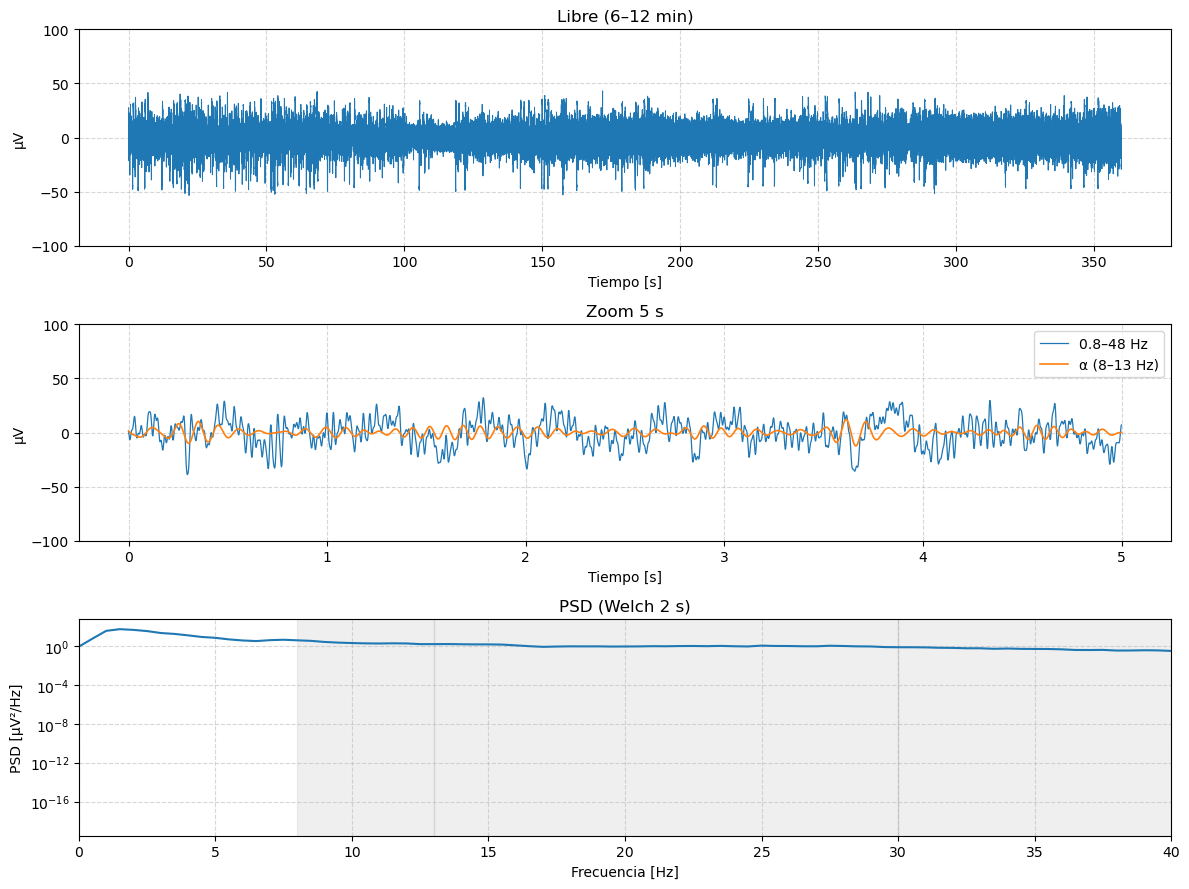

In [30]:
import json, re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch

# ===== Config =====
ruta = "Data_EEG/lab5.txt"
bloque = (360, 720)                # 6–12 min
zoom_window = 5.0               # s
f_lo, f_hi = 0.8, 48.0          # Hz
red, Q_notch = 50.0, 30.0       # cambia red=60.0 si tu red es 60 Hz
BANDAS = {"alpha": (8,13), "beta": (13,30), "gamma": (30,48)}

# ===== Leer header (fs y columna A4) =====
with open(ruta, "r", encoding="utf-8", errors="ignore") as f:
    hdr = []
    while True:
        p = f.tell(); ln = f.readline()
        if not ln: break
        if ln.startswith("#"): hdr.append(ln[1:].strip())
        else: f.seek(p); break
meta = json.loads(re.search(r"\{.*\}", "\n".join(hdr), re.DOTALL).group(0))
dev = next(iter(meta))
fs = int(meta[dev]["sampling rate"])
idx_A4 = meta[dev]["column"].index("A4")

# ===== Cargar y convertir ADC→µV (BITalino EEG) =====
adc = np.genfromtxt(ruta, usecols=[idx_A4], comments="#", dtype=float)
adc = adc[~np.isnan(adc)]
x = (adc - 512.0) * (3.3/1023.0) / 40000.0 * 1e6  # µV

# ===== Filtros: notch + band-pass =====
bN, aN = iirnotch(red/(fs/2), Q_notch)
x = filtfilt(bN, aN, x, method="gust")
bB, aB = butter(4, [f_lo/(fs/2), f_hi/(fs/2)], btype="band")
x = filtfilt(bB, aB, x, method="gust")

# ===== Recorte del bloque =====
i1, i2 = int(bloque[0]*fs), min(int(bloque[1]*fs), len(x))
t = np.arange(len(x))/fs
t_seg, x_seg = t[i1:i2], x[i1:i2]

# ===== Welch (2 s) y potencias por banda (np.trapezoid) =====
f, Pxx = welch(x_seg, fs=fs, nperseg=2*fs, noverlap=fs)
def band_power(f, P, a, b):
    m = (f >= a) & (f <= b)
    return np.trapezoid(P[m], f[m]) if np.any(m) else 0.0
bp = {k: band_power(f, Pxx, a, b) for k,(a,b) in BANDAS.items()}
print("[Basal 1] Potencias (µV²)  α:{:.3f}  β:{:.3f}  γ:{:.3f}".format(bp["alpha"], bp["beta"], bp["gamma"]))

# ===== Zoom 5 s (final del bloque) y α superpuesta =====
t2z = t_seg[-1]; t1z = max(t2z - zoom_window, t_seg[0])
j1, j2 = int(t1z*fs), int(t2z*fs)
t_zoom, x_zoom = t[j1:j2], x[j1:j2]
bA, aA = butter(4, [8/(fs/2), 13/(fs/2)], btype="band")
x_alpha = filtfilt(bA, aA, x_zoom, method="gust")

# ===== Gráficas =====
plt.figure(figsize=(12,9))
ax1 = plt.subplot(3,1,1); ax1.plot(t_seg - t_seg[0], x_seg, lw=.7)
ax1.set_title("Libre (6–12 min)"); ax1.set_xlabel("Tiempo [s]"); ax1.set_ylabel("µV")
ax1.grid(True, ls="--", alpha=.5); ax1.set_ylim(-100, 100)

ax2 = plt.subplot(3,1,2)
ax2.plot(t_zoom - t_zoom[0], x_zoom, lw=.9, label="0.8–48 Hz")
ax2.plot(t_zoom - t_zoom[0], x_alpha, lw=1.2, label="α (8–13 Hz)")
ax2.set_title("Zoom 5 s"); ax2.set_xlabel("Tiempo [s]"); ax2.set_ylabel("µV")
ax2.grid(True, ls="--", alpha=.5); ax2.legend(); ax2.set_ylim(-100, 100)

ax3 = plt.subplot(3,1,3)
ax3.semilogy(f, Pxx)
for a,b in BANDAS.values(): ax3.axvspan(a, b, color="grey", alpha=.12)
ax3.set_xlim(0, 40); ax3.set_xlabel("Frecuencia [Hz]"); ax3.set_ylabel("PSD [µV²/Hz]")
ax3.set_title("PSD (Welch 2 s)"); ax3.grid(True, ls="--", alpha=.5)
plt.tight_layout(); plt.show()